### Problem Statement

You are a data scientist / AI engineer working on a binary classification problem. You have been provided with a dataset named **`"mushroom_classification.csv"`**, which includes various features of mushrooms to predict whether they are edible or poisonous. The dataset comprises the following columns:

- `cap_diameter:` The diameter of the mushroom cap.
- `cap_shape:` The shape of the mushroom cap, encoded as integers.
- `gill_attachment:` The attachment of the gills, encoded as integers.
- `gill_color:` The color of the gills, encoded as integers.
- `stem_height:` The height of the mushroom stem.
- `stem_width` The width of the mushroom stem.
- `stem_color:` The color of the mushroom stem, encoded as integers.
- `season:` The season when the mushroom was found, encoded as float.
- `class:` The classification of the mushroom, where 0 indicates edible and 1 indicates poisonous.

Your task is to use this dataset to build and evaluate a binary classification model to classify mushrooms as edible or poisonous. You will start with basic models and gradually move towards advanced models like Gradient Boosting. Finally, you will explore various parameters of the Gradient Boosting model to enhance performance.

**Dataset credits:** Prisha Sawhney (https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset/data)

**Import Necessary Libraries**

In [13]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# For the *proper* LR later
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42
pd.set_option('display.max_columns', 100)

### Task 1: Data Preparation and Exploration

1. Import the data from the `"mushroom_classification.csv"` file and store it in a variable df.
2. Display the number of rows and columns in the dataset.
3. Display the first few rows of the dataset to get an overview.

In [14]:
# Step 1: Import the data from the "mushroom_classification.csv" file and store it in a variable 'df'
DATA_PATH = "mushroom_classification.csv"
df = pd.read_csv(DATA_PATH)

# Step 2: Display the number of rows and columns in the dataset
print("Shape:", df.shape)
display(df.head())
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())
print("\nUnique values in 'class':", df['class'].unique())


# Step 3: Display the first few rows of the dataset to get an overview


Shape: (54035, 9)


,cap_diameter,cap_shape,gill_attachment,gill_color,stem_height,stem_width,stem_color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1



Dtypes:
 cap_diameter         int64
cap_shape            int64
gill_attachment      int64
gill_color           int64
stem_height        float64
stem_width           int64
stem_color           int64
season             float64
class                int64
dtype: object

Missing values per column:
 cap_diameter       0
cap_shape          0
gill_attachment    0
gill_color         0
stem_height        0
stem_width         0
stem_color         0
season             0
class              0
dtype: int64

Unique values in 'class': [1 0]


### Task 2: Exploratory Data Analysis (EDA)

1. Perform a group-by operation on the target class and calculate the mean of the following features: `cap_diameter, stem_height, and stem_width`.
2. Visualize the distribution of these features using box plots.

In [15]:
# Step 1: Perform a group-by operation on the target class and calculate the mean of specific features
# Features for mean comparison
cols_for_mean = ['cap_diameter', 'stem_height', 'stem_width']

# Group by 'class' and calculate mean
group_means = df.groupby('class')[cols_for_mean].mean()

# Rename class labels for readability
group_means = group_means.rename(index={0: "Edible (0)", 1: "Poisonous (1)"})

display(group_means)

,cap_diameter,stem_height,stem_width
class,,,
Edible (0),633.064696,0.627374,1208.915189
Poisonous (1),513.236293,0.867251,921.516563


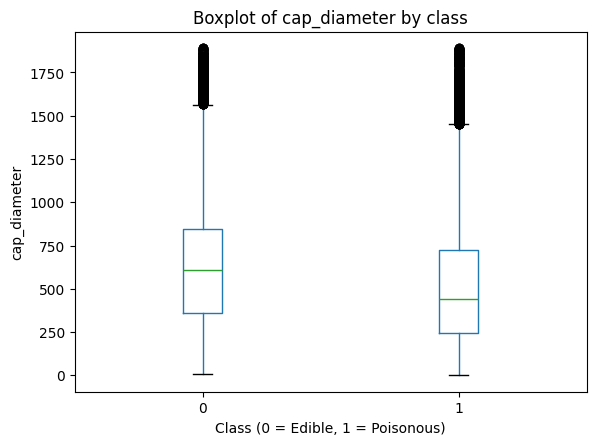

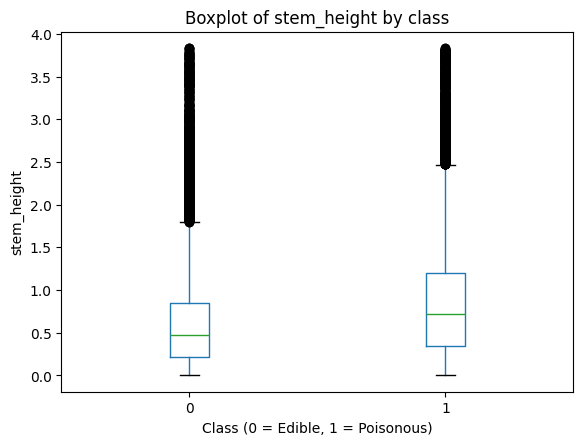

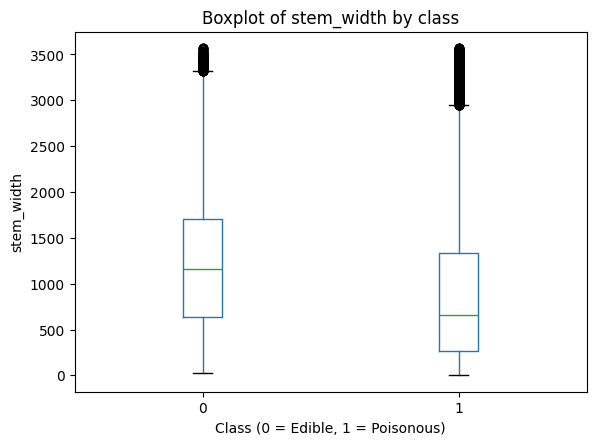

In [16]:
# Step 2: Visualize the distribution of these features using box plots

for col in cols_for_mean:
    df.boxplot(column=col, by='class', grid=False)
    plt.title(f'Boxplot of {col} by class')
    plt.suptitle('')
    plt.xlabel('Class (0 = Edible, 1 = Poisonous)')
    plt.ylabel(col)
    plt.show()

In [17]:
from scipy.stats import ttest_ind

num_cols = ['cap_diameter', 'stem_height', 'stem_width']

for col in num_cols:
    edible = df[df['class'] == 0][col]
    poisonous = df[df['class'] == 1][col]

    diff = edible.mean() - poisonous.mean()
    stat, pval = ttest_ind(edible, poisonous, equal_var=False)

    print(f"{col:15} MeanDiff={diff:.2f}, p-value={pval:.3e}")

cap_diameter    MeanDiff=119.83, p-value=0.000e+00
stem_height     MeanDiff=-0.24, p-value=0.000e+00
stem_width      MeanDiff=287.40, p-value=0.000e+00


In [18]:
cat_cols = ['cap_shape','gill_attachment','gill_color','stem_color','season']

for col in cat_cols:
    ctab = pd.crosstab(df[col], df['class'], normalize='index')
    print(f"\n{col} distribution by class:")
    display(ctab.head())  # only first few rows if many categories


cap_shape distribution by class:


class,0,1
cap_shape,,
0,0.238574,0.761426
1,0.449477,0.550523
2,0.481373,0.518627
3,0.116547,0.883453
4,0.525882,0.474118



gill_attachment distribution by class:


class,0,1
gill_attachment,,
0,0.405669,0.594331
1,0.406942,0.593058
2,0.603040,0.396960
3,0.362590,0.637410
4,0.691345,0.308655



gill_color distribution by class:


class,0,1
gill_color,,
0,0.745016,0.254984
1,0.263456,0.736544
2,0.362590,0.637410
3,0.541721,0.458279
4,0.451467,0.548533



stem_color distribution by class:


class,0,1
stem_color,,
0,1.000000,0.000000
1,0.280501,0.719499
2,0.000000,1.000000
3,0.607007,0.392993
4,0.000000,1.000000



season distribution by class:


class,0,1
season,,
0.027372,0.557008,0.442992
0.888450,0.413155,0.586845
0.943195,0.433885,0.566115
1.804273,0.686182,0.313818


### Task 2.3 – Feature Ranking (EDA Insights)

**Numerical features (mean diff + t-test):**
- **cap_diameter:** Edible mushrooms generally have larger diameters. Strong separation.  
- **stem_height:** Poisonous mushrooms have taller stems. Moderate signal.  
- **stem_width:** Edible mushrooms have thicker stems. Strong separation.  

**Categorical features (distribution differences):**
- **stem_color:** Very strong predictor. Some values (e.g., category 0 → 100% edible; 2/4 → 100% poisonous) almost perfectly separate classes.  
- **gill_color:** Strong predictor. Example: category 0 → 75% edible, category 1 → 74% poisonous.  
- **cap_shape / gill_attachment:** Some categories skew strongly edible vs poisonous, useful but less sharp.  
- **season:** Shows some imbalance, but weaker signal compared to others.  

**Overall ranking (by predictive strength from EDA intuition):**
1. stem_color  
2. gill_color  
3. stem_width / cap_diameter  
4. stem_height  
5. cap_shape / gill_attachment  
6. season  

**Conclusion:**  
Stem color and gill color are the strongest categorical predictors. Among numeric features, stem width and cap diameter show strong separation, while stem height has moderate signal. Season provides the weakest separation.  

##	•	“From the boxplots, stem height and stem width show some separation between edible and poisonous
mushrooms. Poisonous mushrooms generally have taller stems, while edible ones have thicker stems. 
    Cap diameter shows differences but with higher overlap. These features are not perfect 
separators but provide useful signal for classification.”


### Task 3: Model Training Using Basic Models

1. Select the features `(cap_diameter, cap_shape, gill_attachment, gill_color, stem_height, stem_width, stem_color, season)` and the target variable `(class)` for modeling.
2. Split the data into training and test sets with a test size of 25%.
3. Initialize and train a Logistic Regression model using the training data.
4. Make predictions on the test set using the trained model.
5. Evaluate the model using a classification report and print the report.
6. Initialize and train a Decision Tree Classifier model using the training data.
7. Make predictions on the test set using the trained model.
8. Evaluate the model using a classification report and print the report.

In [19]:
# Step 1: Select the features and target variable for modeling
feature_cols = ['cap_diameter','cap_shape','gill_attachment','gill_color',
                'stem_height','stem_width','stem_color','season']

X = df[feature_cols]
y = df['class']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

X_train.shape, X_test.shape
# Step 2: Split the data into training and test sets with a test size of 25%


((40526, 8), (13509, 8))

In [20]:
# Step 3: Initialize and train a Logistic Regression model using the training data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 4: Make predictions on the test set using the trained model
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

# Step 5: Evaluate the model using a classification report and print the report
print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, digits=4))

LR Accuracy: 0.6405359390036273

Confusion Matrix:
 [[3350 2740]
 [2116 5303]]

Classification Report:
               precision    recall  f1-score   support

           0     0.6129    0.5501    0.5798      6090
           1     0.6593    0.7148    0.6859      7419

    accuracy                         0.6405     13509
   macro avg     0.6361    0.6324    0.6329     13509
weighted avg     0.6384    0.6405    0.6381     13509



In [22]:
# Step 6: Initialize and train a Decision Tree Classifier model using the training data
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("DT Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, digits=4))

# Step 7: Make predictions on the test set using the trained model


# Step 8: Evaluate the model using a classification report and print the report



DT Accuracy: 0.9771263602043082

Confusion Matrix:
 [[5941  149]
 [ 160 7259]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9738    0.9755    0.9747      6090
           1     0.9799    0.9784    0.9792      7419

    accuracy                         0.9771     13509
   macro avg     0.9768    0.9770    0.9769     13509
weighted avg     0.9771    0.9771    0.9771     13509



In [23]:
#Quick check on the test data 
train_acc = dt.score(X_train, y_train)
test_acc  = dt.score(X_test,  y_test)
train_acc, test_acc

(1.0, 0.9771263602043082)

In [24]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(DecisionTreeClassifier(random_state=42),
                            X, y, cv=5, scoring='accuracy')
cv_scores.mean(), cv_scores

(np.float64(0.5395576940871657),
 array([0.55038401, 0.45886925, 0.51596188, 0.5693532 , 0.60322014]))

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt_pruned = DecisionTreeClassifier(
    random_state=42,
    max_depth=8,              # try 6–12
    min_samples_leaf=10,      # try 5–50
)
dt_pruned.fit(X_train, y_train)
print("Pruned DT Test Acc:", dt_pruned.score(X_test, y_test))

Pruned DT Test Acc: 0.8342586423865571


In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_dt)
tn, fp, fn, tp = cm.ravel()
print("Poisonous→Edible (FN):", fn, "  Edible→Poisonous (FP):", fp)

Poisonous→Edible (FN): 160   Edible→Poisonous (FP): 149


In [27]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_base = DecisionTreeClassifier(random_state=42)
cv_scores = cross_val_score(dt_base, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
cv_scores.mean(), cv_scores

(np.float64(0.9767372998982141),
 array([0.97751457, 0.9736282 , 0.97575645, 0.97834737, 0.9784399 ]))

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'max_features': [None, 'sqrt', 'log2']
}
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'max_depth': None,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 np.float64(0.9767372998982141))

Poisonous→Edible (FN): 160   Edible→Poisonous (FP): 149

### Task 4: Model Training Using Gradient Boosting Classifier

1. Initialize and train a Gradient Boosting Classifier model using the training data.
2. Make predictions on the test set using the trained model.
3. Evaluate the model using a classification report and print the report.
4. Calculate and display the feature importances.

In [32]:
# Step 1: Initialize and train a Gradient Boosting Classifier model using the training data

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

y_pred_gb  = gb.predict(X_test)
y_prob_gb  = gb.predict_proba(X_test)[:, 1]

print("GB (default) Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_gb))
# Step 2: Make predictions on the test set using the trained model


# Step 3: Evaluate the model using a classification report and print the report


GB (default) Accuracy: 0.8755644385224665

Confusion Matrix:
 [[5303  787]
 [ 894 6525]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8557    0.8708    0.8632      6090
           1     0.8924    0.8795    0.8859      7419

    accuracy                         0.8756     13509
   macro avg     0.8741    0.8751    0.8745     13509
weighted avg     0.8759    0.8756    0.8757     13509

ROC-AUC: 0.9397552571604748


,feature,importance
5,stem_width,0.242145
2,gill_attachment,0.171381
6,stem_color,0.151951
4,stem_height,0.136804
1,cap_shape,0.116219
3,gill_color,0.089699
0,cap_diameter,0.049024
7,season,0.042777


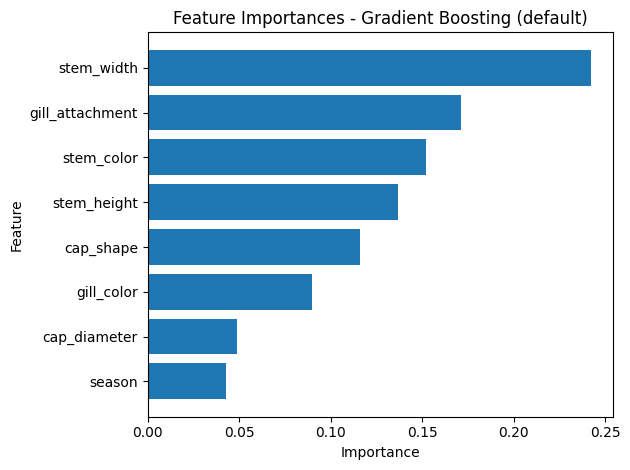

In [33]:
# Step 4: Calculate and display the feature importances
imp = (pd.DataFrame({'feature': X.columns, 'importance': gb.feature_importances_})
         .sort_values('importance', ascending=False))
display(imp)

# quick barh
plt.figure()
plt.barh(imp['feature'], imp['importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances - Gradient Boosting (default)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Task 5: Exploring Various Parameters in Gradient Boosting Classifier

1. Train a Gradient Boosting model with the following parameters:
    - learning_rate = 0.05
    - n_estimators = 150
    - max_depth=4
    - min_samples_split = 3
    - min_samples_leaf = 2

Learn about these parameters here: [scikit-learn GradientBoostingClassifier Parameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

-------------------------------------------------------------------------------------------------------------------------------------------------------
2. Evaluate the model using a classification report and print the report.

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Step 1: Train Gradient Boosting with given parameters
gb_custom = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=150,
    max_depth=4,
    min_samples_split=3,
    min_samples_leaf=2,
    random_state=42
)
gb_custom.fit(X_train, y_train)

# Step 2: Predictions
y_pred_gb_c = gb_custom.predict(X_test)
y_prob_gb_c = gb_custom.predict_proba(X_test)[:, 1]

# Step 3: Evaluation
print("Custom GB Accuracy:", accuracy_score(y_test, y_pred_gb_c))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gb_c))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb_c, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_gb_c))

Custom GB Accuracy: 0.9023613887038271

Confusion Matrix:
 [[5502  588]
 [ 731 6688]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8827    0.9034    0.8930      6090
           1     0.9192    0.9015    0.9102      7419

    accuracy                         0.9024     13509
   macro avg     0.9010    0.9025    0.9016     13509
weighted avg     0.9027    0.9024    0.9025     13509

ROC-AUC: 0.9641732130103088



Feature Importances:
            feature  importance
5       stem_width    0.257702
2  gill_attachment    0.200667
6       stem_color    0.137904
3       gill_color    0.116033
4      stem_height    0.114380
1        cap_shape    0.079154
0     cap_diameter    0.056600
7           season    0.037560


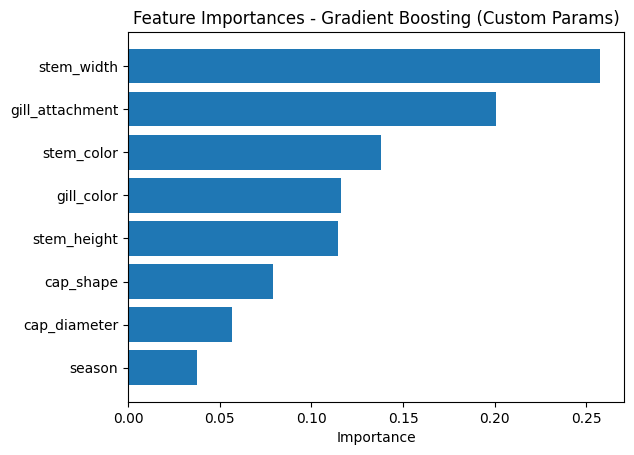

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

imp_custom = (pd.DataFrame({
    'feature': X.columns,
    'importance': gb_custom.feature_importances_
}).sort_values('importance', ascending=False))

print("\nFeature Importances:\n", imp_custom)

# Plot
plt.figure()
plt.barh(imp_custom['feature'], imp_custom['importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importances - Gradient Boosting (Custom Params)")
plt.xlabel("Importance")
plt.show()